<a href="https://colab.research.google.com/github/elmahygurl/NLP_sst_Classification/blob/main/NLP_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting dataset

In [21]:
!pip install datasets

In [22]:
from datasets import load_dataset, Dataset


In [23]:
sst_dataset = load_dataset('sst')

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for sst contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sst
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [24]:
print(sst_dataset['train'][500])
print(f"Number of training examples: {len(sst_dataset['train'])}")
print(f"Number of validation examples: {len(sst_dataset['validation'])}")
print(f"Number of test examples: {len(sst_dataset['test'])}")

{'sentence': 'This story still seems timely and important .', 'label': 0.6944400072097778, 'tokens': 'This|story|still|seems|timely|and|important|.', 'tree': '14|14|13|11|9|9|10|12|10|11|12|13|15|15|0'}
Number of training examples: 8544
Number of validation examples: 1101
Number of test examples: 2210


# Preprocessing

Removing the 'tree' column and adjusting the labels to accomodate the 5 classes we want to classify to where:
From 0 to 0.2 (0.2 included) will be class 0 “very negative”.

From 0.2 to 0.4 (0.4 included) will be class 1 “negative”.

From 0.4 to 0.6 (0.6 included) will be class 2 “neutral”.

From 0.6 to 0.8 (0.8 included) will be class 3 “positive”.

From 0.8 to 1.0 (1.0 included) will be class 4 “very positive”.

In [25]:
#converting splits to Pandas DataFrame for manipulation
import pandas as pd
train_df = pd.DataFrame(sst_dataset['train'])
test_df = pd.DataFrame(sst_dataset['test'])
val_df = pd.DataFrame(sst_dataset['validation'])

#function to map float labels to our desired categorical classes
def map_labels_to_categories(label):
    if 0.0 <= label <= 0.2:
        return 0  # very negative
    elif 0.2 < label <= 0.4:
        return 1  # negative
    elif 0.4 < label <= 0.6:
        return 2  # neutral
    elif 0.6 < label <= 0.8:
        return 3  # positive
    elif 0.8 < label <= 1.0:
        return 4  # very positive

#mapping function to create a new column with mapped labels
train_df['mapped_label'] = train_df['label'].apply(map_labels_to_categories)
test_df['mapped_label'] = test_df['label'].apply(map_labels_to_categories)
val_df['mapped_label'] = val_df['label'].apply(map_labels_to_categories)

#dropping the original label column
train_df = train_df.drop('label', axis=1)
test_df = test_df.drop('label', axis=1)
val_df = val_df.drop('label', axis=1)

train_df = train_df.drop(columns=['tree']) #dropping 'tree' column
test_df = test_df.drop(columns=['tree'])
val_df = val_df.drop(columns=['tree'])

######just to print an output and visualise
#convert the DataFrame back to the datasets format
sst_dataset['train'] = Dataset.from_pandas(train_df)
sst_dataset['test'] = Dataset.from_pandas(test_df)
sst_dataset['validation'] = Dataset.from_pandas(val_df)

#display the updated dataset
print(sst_dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'tokens', 'mapped_label'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'tokens', 'mapped_label'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'tokens', 'mapped_label'],
        num_rows: 2210
    })
})


In [26]:
#analyzing the distribution of labels
train_label_distribution = train_df['mapped_label'].value_counts().sort_index()
test_label_distribution = test_df['mapped_label'].value_counts().sort_index()
val_label_distribution = val_df['mapped_label'].value_counts().sort_index()

print("Training Split Label Distribution:")
print(train_label_distribution)

print("\nTest Split Label Distribution:")
print(test_label_distribution)

print("\nValidation Split Label Distribution:")
print(val_label_distribution)


Training Split Label Distribution:
0    1092
1    2218
2    1624
3    2322
4    1288
Name: mapped_label, dtype: int64

Test Split Label Distribution:
0    279
1    633
2    389
3    510
4    399
Name: mapped_label, dtype: int64

Validation Split Label Distribution:
0    139
1    289
2    229
3    279
4    165
Name: mapped_label, dtype: int64


### Visualisation for us

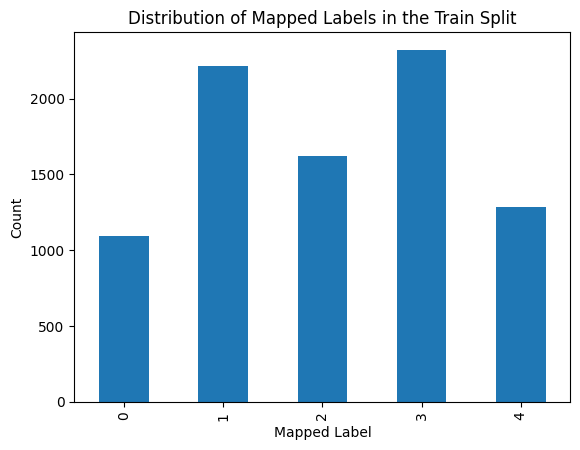

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
train_df = pd.DataFrame(sst_dataset['train']) #convert the 'train' split to a Pandas DataFrame

# Plot the distribution of mapped labels in the 'train' split
train_df['mapped_label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Mapped Labels in the Train Split')
plt.xlabel('Mapped Label')
plt.ylabel('Count')
plt.show()

In [30]:
#print first few rows of the 'train' split to see the transformed data
print(train_df.head())

#to ensure correct mapping
print("Unique values in mapped_labels = ",train_df['mapped_label'].unique())

#check for missing values in the 'mapped_label' column of the 'train' split
print("Missing = ",train_df['mapped_label'].isnull().sum())


                                            sentence  \
0  The Rock is destined to be the 21st Century 's...   
1  The gorgeously elaborate continuation of `` Th...   
2  Singer\/composer Bryan Adams contributes a sle...   
3  You 'd think by now America would have had eno...   
4               Yet the act is still charming here .   

                                              tokens  mapped_label  
0  The|Rock|is|destined|to|be|the|21st|Century|'s...             3  
1  The|gorgeously|elaborate|continuation|of|``|Th...             4  
2  Singer\/composer|Bryan|Adams|contributes|a|sle...             3  
3  You|'d|think|by|now|America|would|have|had|eno...             2  
4               Yet|the|act|is|still|charming|here|.             3  
Unique values in mapped_labels =  [3 4 2 1 0]
Missing =  0


## Naive Bayes


In [31]:
import numpy as np
def train_naive_bayes(D, C):
    Ndoc = len(D)   #total number of documents in training dataset D
    Nc = np.array([np.sum(D['mapped_label'] == c) for c in C]) #calculates no. of documents in D that belong to each class in C
    logprior = np.log(Nc / Ndoc) #calculating prior probability of each class

    #building vocabulary of D
    V = set()
    for doc in D['sentence']:
        V.update(doc.split())  #adding to V so it has unique words
    V = list(V) #converting to list

    #calculating P(w|c) terms
    bigdoc = {}  #new dictionary
    for c in C:
        bigdoc[c] = ' '.join(D[D['mapped_label'] == c]['sentence']).split() #concatenate sentences of documents belonging to each class and split them into words

    #calculating frequency of each word in vocabulary for each class and store counts in a 2D NumPy array count
    count = np.zeros((len(V), len(C)))
    for i, word in enumerate(V):
        for j, c in enumerate(C):
            count[i, j] = bigdoc[c].count(word)

    #calculate log likelihoods of each word given each class
    #using Laplace smoothing to avoid zero probabilities
    loglikelihood = np.log((count + 1) / (np.sum(count, axis=0, keepdims=True) + len(V)))

    return logprior, loglikelihood, V

def test_naive_bayes(testdoc, logprior, loglikelihood, C, V):
    sum_ = np.zeros(len(C))  # to store log probabilities of each class for the given testdoc
    for c in C:
        sum_[c] = logprior[c]
        for word in testdoc.split():
            if word in V:  #if present in vocab
                sum_[c] += loglikelihood[V.index(word), c]

    return np.argmax(sum_) #returns index of the class with the highest log probability (indicating predicted class for the testdoc)

#list with the classes we have (aka labels)
C = [0, 1, 2, 3, 4]

#Trainingg
logprior, loglikelihood, V = train_naive_bayes(train_df, C)

#Testingg
correct = 0
total = len(test_df)
for i in range(total):
    predicted_label = test_naive_bayes(test_df.iloc[i]['sentence'], logprior, loglikelihood, C, V)
    if predicted_label == test_df.iloc[i]['mapped_label']:
        correct += 1

accuracy = correct / total
print("Accuracy when splitting sentence:", accuracy)


Accuracy when splitting sentence: 0.39683257918552034


#####same thing but with existing tokens in dataset not spliting the sentence

In [33]:
def train_naive_bayes1(D, C):
    #calculate P(c) terms
    Ndoc = len(D)
    Nc = np.array([np.sum(D['mapped_label'] == c) for c in C])
    logprior = np.log(Nc / Ndoc)

    # building vocab with existing tokens in dataset
    V = set()
    for tokens in D['tokens']:
        V.update(tokens)
    V = list(V)

    #calculate P(w|c) terms
    bigdoc = {}
    for c in C:
        bigdoc[c] = [token for tokens in D[D['mapped_label'] == c]['tokens'] for token in tokens]

    count = np.zeros((len(V), len(C)))
    for i, word in enumerate(V):
        for j, c in enumerate(C):
            count[i, j] = bigdoc[c].count(word)

    loglikelihood = np.log((count + 1) / (np.sum(count, axis=0, keepdims=True) + len(V)))

    return logprior, loglikelihood, V

def test_naive_bayes1(testdoc, logprior, loglikelihood, C, V):
    sum_ = np.zeros(len(C))
    for c in C:
        sum_[c] = logprior[c]
        for word in testdoc:
            if word in V:
                sum_[c] += loglikelihood[V.index(word), c]

    return np.argmax(sum_)

#classes
C = [0, 1, 2, 3, 4]

logprior, loglikelihood, V = train_naive_bayes1(train_df, C)

correct = 0
total = len(test_df)
for i in range(total):
    predicted_label = test_naive_bayes1(test_df.iloc[i]['tokens'], logprior, loglikelihood, C, V)
    if predicted_label == test_df.iloc[i]['mapped_label']:
        correct += 1

accuracy = correct / total
print("Accuracy with existing tokens in dataset:", accuracy)


Accuracy with existing tokens in dataset: 0.2864253393665158


####Metrics and comparison with sklearn

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

#create pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB(alpha=1.0))  # Alpha parameter for Laplace smoothing
    ])

#Train pipeline
pipeline.fit(train_df['sentence'], train_df['mapped_label'])


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [38]:
# Make predictions
predictions_sklearn = pipeline.predict(test_df['sentence'])

accuracy_sklearn = accuracy_score(test_df['mapped_label'], predictions_sklearn)
print("Accuracy (scikit-learn):", accuracy_sklearn)


Accuracy (scikit-learn): 0.4090497737556561


In [46]:
#  function to make the Confusion Matrix
def confusion_matrix_numpy(y_true, y_pred, num_classes):
    confusion_mat = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        confusion_mat[true][pred] += 1
    return confusion_mat

conf_matrix_numpy = confusion_matrix_numpy(test_df['mapped_label'], predictions_sklearn, len(C))
print("Confusion Matrix (only using numpy):\n", conf_matrix_numpy)

# Precision, Recall, and F1 score per class
def precision_recall_f1_numpy(conf_matrix):
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

precision_numpy, recall_numpy, f1_numpy = precision_recall_f1_numpy(conf_matrix_numpy)
print("Precision:", precision_numpy)
print("Recall:", recall_numpy)
print("F1 Score:", f1_numpy)

# Macro-averaged Precision, Recall, and F1 score
def macro_averaged_metrics_numpy(precision, recall, f1):
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    return macro_precision, macro_recall, macro_f1

precision_macro_numpy, recall_macro_numpy, f1_macro_numpy = macro_averaged_metrics_numpy(precision_numpy, recall_numpy, f1_numpy)
print("Macro-averaged Precision:", precision_macro_numpy)
print("Macro-averaged Recall:", recall_macro_numpy)
print("Macro-averaged F1 Score:", f1_macro_numpy)


Confusion Matrix (only using numpy):
 [[ 28 200  10  41   0]
 [ 22 415  57 127  12]
 [  8 154  34 181  12]
 [  2  88  39 340  41]
 [  2  39  12 259  87]]
Precision: [0.4516129  0.46316964 0.22368421 0.35864979 0.57236842]
Recall: [0.10035842 0.65560821 0.0874036  0.66666667 0.21804511]
F1 Score: [0.16422287 0.54283846 0.12569316 0.46639232 0.31578947]
Macro-averaged Precision: 0.41389699333828645
Macro-averaged Recall: 0.3456164032418666
Macro-averaged F1 Score: 0.3229872566299008


##### better representation (for us)

In [51]:
import pandas as pd

#create DataFrame for precision, recall, and F1 score
metrics_df = pd.DataFrame({
    'Precision': precision_numpy,
    'Recall': recall_numpy,
    'F1 Score': f1_numpy
}, index=C)  # Assuming C contains the class labels


# create DataFrame for macro-averaged precision, recall, and F1 score
macro_metrics_df = pd.DataFrame({
    'Precision': [precision_macro_numpy],
    'Recall': [recall_macro_numpy],
    'F1 Score': [f1_macro_numpy]
})

print("Metrics per class (scikit-learn):\n", metrics_df)
print("-------------------------------------")
print("Macro-averaged Metrics (scikit-learn):\n", macro_metrics_df)


Metrics per class (scikit-learn):
    Precision    Recall  F1 Score
0   0.451613  0.100358  0.164223
1   0.463170  0.655608  0.542838
2   0.223684  0.087404  0.125693
3   0.358650  0.666667  0.466392
4   0.572368  0.218045  0.315789
-------------------------------------
Macro-averaged Metrics (scikit-learn):
    Precision    Recall  F1 Score
0   0.413897  0.345616  0.322987


# Logistic regression

In [ ]:
import numpy as np

def features_extract(data):
    # Initialize a set to store sentence and bigrams pairs
    sentence_bigrams_set = set()
    unique_bigrams = set()

    # Extract relevant information from the dataset
    for i in range(len(data)):
        # Initialize a list to store unique word bi-grams
        sentence = data['sentence'][i]
        tokens = data['tokens'][i].split('|')

        # Build bigrams
        bigrams = [f"{tokens[j]} {tokens[j + 1]}" for j in range(len(tokens) - 1)]

        # Add the pair to the set
        sentence_bigrams_set.add((sentence, tuple(bigrams)))
        unique_bigrams.update(bigrams)  # Updated this line

    # Create a list of unique words
    unique_words = sorted(list(set(word for sentence in data['tokens'] for word in sentence.split('|'))))

    # Create a binary matrix to store bigram existence
    bigram_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=int)

    # Populate the matrix
    for i, word1 in enumerate(unique_words):
        for j, word2 in enumerate(unique_words):
            # Convert (word1, word2) to a tuple for comparison
            current_bigram = f"{word1} {word2}"
            if current_bigram in unique_bigrams:
                bigram_matrix[i, j] = 1

    return bigram_matrix, unique_words


train_dataset = sst_dataset['train']
binary_bigram_matrix, unique_words = features_extract(train_dataset)

# Print the resulting matrix
print("Binary Bigram Matrix:")
print(binary_bigram_matrix)


Binary Bigram Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
import numpy as np

# Assuming 'matrix' is your matrix
matrix_sum = np.sum(binary_bigram_matrix)

# Print the result
print("Sum of all elements in the matrix:", matrix_sum)


Sum of all elements in the matrix: 87247


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MultiClassLogisticRegression:

    def __init__(self, n_iter=10000, thres=1e-3):
        self.n_iter = n_iter
        self.thres = thres
        self.classes = ['0', '1', '2', '3', '4']
        self.class_labels = [0, 1, 2, 3, 4]

    def fit(self, X, y, batch_size=64, lr=0.001, rand_seed=4, verbose=False):
        np.random.seed(rand_seed)
        X = self.add_bias(X)
        y = self.one_hot(y)
        self.loss = []
        self.weights = np.zeros(shape=(len(self.classes), X.shape[1]))
        self.fit_data(X, y, batch_size, lr, verbose)
        return self

    def fit_data(self, X, y, batch_size, lr, verbose):
        i = 0
        while (not self.n_iter or i < self.n_iter):
            self.loss.append(self.cross_entropy(y, self.predict_(X)))
            idx = np.random.choice(X.shape[0], batch_size)
            X_batch, y_batch = X[idx], y[idx]
            error = y_batch - self.predict_(X_batch)
            update = (lr * np.dot(error.T, X_batch))
            self.weights += update
            if np.abs(update).max() < self.thres:
                break
            if i % 1000 == 0 and verbose:
                print('Training Accuracy at {} iterations is {}'.format(i, self.evaluate_(X, y)))
            i += 1

    def predict(self, X):
        return self.predict_(self.add_bias(X))

    def predict_(self, X):
        pre_vals = np.dot(X, self.weights.T).reshape(-1, len(self.classes))
        return self.softmax(pre_vals)

    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)

    def predict_classes(self, X):
        self.probs_ = self.predict(X)
        return np.vectorize(lambda c: self.classes[c])(np.argmax(self.probs_, axis=1))

    def add_bias(self, X):
        return np.insert(X, 0, 1, axis=1)

    def one_hot(self, y):
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]

    def score(self, X, y):
        return np.mean(self.predict_classes(X) == y)

    def evaluate_(self, X, y):
        return np.mean(np.argmax(self.predict_(X), axis=1) == np.argmax(y, axis=1))



    def cross_entropy(self, y, probs):
      exp_logits = np.exp(y - np.max(y, axis=1, keepdims=True))
      softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

      # Avoid numerical instability by adding a small epsilon
      epsilon = 1e-15
      softmax_probs = np.clip(softmax_probs, epsilon, 1 - epsilon)

      # Calculate cross-entropy loss
      loss = -np.sum(labels * np.log(softmax_probs)) / len(logits)

      return loss

# from sklearn import datasets
# X,y = datasets.load_iris(return_X_y=True)
# lr = MultiClassLogisticRegression(thres=1e-5)
# lr.fit(X,y,lr=0.0001)
# print(lr.score(X, y))


# Example usage
multireg = MultiClassLogisticRegression(n_iter=5000)
y = train_dataset['mapped_label']
my_array = np.array(y)
print(type(my_array))
multireg.fit(binary_bigram_matrix,my_array , lr=0.01, batch_size=128, verbose=True)


<class 'numpy.ndarray'>


ValueError: operands could not be broadcast together with shapes (18280,5) (8544,5) 